In [3]:
cd ..

C:\Personal_Data\Machine_Learning_Project\Medical_Information_Extraction\mrec


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import NuSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix, classification_report
from mrec.data.dataset import load_data
from mrec.features.transform import clean_text

In [153]:
# Read in training, validation data and labels
dataset = load_data(csv_fnames)
train, validation, test = dataset.train, dataset.validation, dataset.test

relation_type = ['causes', 'treats']
train = train[['sentence', 'relation']][train['relation'].isin(relation_type)].drop_duplicates()
validation = validation[['sentence', 'relation']][validation['relation'].isin(relation_type)].drop_duplicates()
test = test[['sentence', 'relation']][test['relation'].isin(relation_type)].drop_duplicates()

#TODO add feature engineering
count_vect = CountVectorizer(ngram_range=(1, 3), analyzer=clean_text)
X_counts_train = count_vect.fit_transform(train['sentence'])
X_train_label = train['relation']

most_popular_word_df = pd.DataFrame(X_counts_train.toarray(), columns=count_vect.get_feature_names())

X_counts_validation = count_vect.transform(validation['sentence'])
X_validation_label = validation['relation']

X_counts_test = count_vect.transform(test['sentence'])
X_test_label = test['relation']


[2020-12-22 15:41:24,765] [DEBUG] [mrec.data.dataset::load_data::48] Loaded dataset (train:dataset/raw/train.csv)
[2020-12-22 15:41:24,791] [DEBUG] [mrec.data.dataset::load_data::48] Loaded dataset (validation:dataset/raw/validation.csv)
[2020-12-22 15:41:24,819] [DEBUG] [mrec.data.dataset::load_data::48] Loaded dataset (test:dataset/raw/test.csv)


In [186]:
temp_df = pd.DataFrame(most_popular_word_df.sum(axis=0), columns=['count']).sort_values(by='count', ascending=False)
count_vec_top_200 = list(temp_df['count'][:200].index)
count_vec_top_200

['patient',
 'treatment',
 'cause',
 'disease',
 'may',
 'pain',
 'use',
 'infection',
 '1',
 'syndrome',
 'study',
 'therapy',
 '2',
 'et',
 'drug',
 'al',
 'b',
 'trial',
 '•',
 'control',
 'symptom',
 'type',
 'case',
 'agent',
 'increase',
 'present',
 'include',
 'hypertension',
 'associate',
 'result',
 'virus',
 'acute',
 'cell',
 'effect',
 'clinical',
 'treat',
 'diabetes',
 'disorder',
 'severe',
 'chronic',
 'high',
 'risk',
 'fever',
 'seizure',
 'low',
 'dose',
 'reduce',
 'c',
 'insulin',
 'oral',
 'effective',
 'report',
 'diarrhea',
 'eg',
 'show',
 'child',
 'combination',
 'diagnosis',
 'also',
 'bone',
 'receive',
 'compare',
 'efficacy',
 'see',
 'randomize',
 '3',
 'headache',
 'response',
 'woman',
 'year',
 'carcinoma',
 'characterize',
 'term',
 'related',
 'pregnancy',
 'group',
 'arthritis',
 'human',
 'consider',
 'cancer',
 'often',
 'allergic',
 'renal',
 'follow',
 'skin',
 'acid',
 'prevent',
 'epilepsy',
 'without',
 'usually',
 'placebo',
 'mg',
 'sugge

In [66]:
def print_metric(gtruth, predictions, dset_name):
    """Print 5 scoring metrics: accuracy, roc_auc, f1, precision, and recall

    Args:
        gtruth (array): label (either 0 or 1)
        predictions (array): model prediction (either 0 or 1)
        dset_name: the dataset that is evaluating on
    """
    accuracy = round(accuracy_score(gtruth, predictions), 4)
    roc_auc = round(roc_auc_score(gtruth, predictions), 4)
    f1 = round(f1_score(gtruth, predictions), 4)
    precision = round(precision_score(gtruth, predictions), 4)
    recall = round(recall_score(gtruth, predictions), 4)
    print('{:>10} {:>11} {:>12} {:>12} {:>11} {:>12}'.format(dset_name, accuracy, roc_auc, f1, precision, recall))

def evaluate_model(model, X, y, dset_name):
    """Evaluate on given model

    Args:
        model: NuSVC()
        X: countvectorizers of feature(s)
        y: label
        dset_name: dataset that is evaluating on
    """
    enc = LabelEncoder()

    predictions = model.predict(X)
    gtruth = enc.fit_transform(y)
    encoder_predictions = enc.transform(predictions)

    print_metric(gtruth, encoder_predictions, dset_name)
    return predictions

In [207]:
"""Train the best model"""
model = NuSVC()

print('Training model..')
model.fit(X_counts_train, X_train_label)

print('{:>23} {:>12} {:>12} {:>12} {:>10}'.format('Accuracy', 'ROC_AUC', 'F1-score', 'Precision', 'Recall'))
evaluate_model(model, X_counts_train, X_train_label, 'Train')

val_predictions = evaluate_model(model, X_counts_validation, X_validation_label, 'Validation')

predictions = evaluate_model(model, X_counts_test, X_test_label, 'Test')

Training model..
               Accuracy      ROC_AUC     F1-score    Precision     Recall
     Train      0.9615       0.9589       0.9545      0.9692       0.9403
Validation      0.7966       0.7942       0.7771      0.8085        0.748
      Test      0.8293       0.8242       0.8017      0.8251       0.7797


[2020-12-22 15:18:11,780] [DEBUG] [matplotlib.colorbar::_get_ticker_locator_formatter::600] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000147FA77B940>
[2020-12-22 15:18:11,781] [DEBUG] [matplotlib.colorbar::update_ticks::645] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000147FA77B940> on colorbar
[2020-12-22 15:18:11,781] [DEBUG] [matplotlib.colorbar::_add_solids::802] Setting pcolormesh


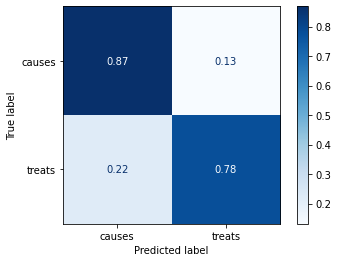

In [148]:
class_names = X_test_label.unique()
plot_confusion_matrix(model, X_counts_test, X_test_label,
                      display_labels=class_names,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.show()

In [149]:
enc = LabelEncoder()
gtruth = enc.fit_transform(X_test_label)
encoder_predictions = enc.transform(predictions)
print(classification_report(gtruth, encoder_predictions, target_names=class_names))

              precision    recall  f1-score   support

      causes       0.83      0.87      0.85       297
      treats       0.83      0.78      0.80       236

    accuracy                           0.83       533
   macro avg       0.83      0.82      0.83       533
weighted avg       0.83      0.83      0.83       533



In [75]:
csv_fnames = {'train': 'dataset/raw/train.csv', 'validation': 'dataset/raw/validation.csv',
              'test': 'dataset/raw/test.csv'}
relation_type = ['causes', 'treats']
dataset = load_data(csv_fnames)
train_df, validation_df, test_df = dataset.train, dataset.validation, dataset.test

train_df = train_df[['sentence', 'relation']][train_df['relation'].isin(relation_type)].drop_duplicates()
validation_df = validation_df[['sentence', 'relation']][validation_df['relation'].isin(relation_type)].drop_duplicates()
test_df = test_df[['sentence', 'relation']][test_df['relation'].isin(relation_type)].drop_duplicates()

[2020-12-22 13:30:15,690] [DEBUG] [mrec.data.dataset::load_data::48] Loaded dataset (train:dataset/raw/train.csv)
[2020-12-22 13:30:15,711] [DEBUG] [mrec.data.dataset::load_data::48] Loaded dataset (validation:dataset/raw/validation.csv)
[2020-12-22 13:30:15,734] [DEBUG] [mrec.data.dataset::load_data::48] Loaded dataset (test:dataset/raw/test.csv)


## Reasson why model fails to classify relation in test set

In [79]:
test_df['pred'] = predictions
false_pred_df = test_df[test_df['relation'] != test_df['pred']]
false_pred_df

,sentence,relation,pred
28,"Clonidine, oxymetazoline, tetrahydozoline, bri...",treats,causes
42,With successful treatment of the patient's dep...,causes,treats
56,The therapeutic results of Lp TAE (transcathet...,causes,treats
294,INSULIN PEPTIDE B9 23 is a major autoantigen i...,treats,causes
364,Update: Prevention of HEPATITIS A after exposu...,causes,treats
...,...,...,...
4503,• Progressive loss of epinephrine and GLUCAGON...,treats,causes
4510,Hemoperfusion Hemoperfusion through columns o...,treats,causes
4517,Continuous epidural analgesia with 0.1% bupiva...,treats,causes
4524,2 Confirm congenital antithrombin III deficie...,treats,causes


In [206]:
false_pred_df.iloc[1].sentence

"With successful treatment of the patient's depression with IMIPRAMINE the tremors disappeared, but slowly began again after drug noncompliance resulted in recurrence of DEPRESSION."

In [205]:
raw = dataset.train[['_unit_id', 'relation', 'sentence', 'direction', 'term1', 'term2']]
raw[raw['sentence'] == "INSULIN PEPTIDE B9 23 is a major autoantigen in TYPE 1 DIABETES"]

,_unit_id,relation,sentence,direction,term1,term2
805,502904695,causes,INSULIN PEPTIDE B9 23 is a major autoantigen i...,no_relation,TYPE 1 DIABETES,INSULIN PEPTIDE B9 23
806,502904695,causes,INSULIN PEPTIDE B9 23 is a major autoantigen i...,no_relation,TYPE 1 DIABETES,INSULIN PEPTIDE B9 23
807,502904695,causes,INSULIN PEPTIDE B9 23 is a major autoantigen i...,no_relation,TYPE 1 DIABETES,INSULIN PEPTIDE B9 23
808,502904695,causes,INSULIN PEPTIDE B9 23 is a major autoantigen i...,no_relation,TYPE 1 DIABETES,INSULIN PEPTIDE B9 23
809,502904695,causes,INSULIN PEPTIDE B9 23 is a major autoantigen i...,no_relation,TYPE 1 DIABETES,INSULIN PEPTIDE B9 23
810,502904695,causes,INSULIN PEPTIDE B9 23 is a major autoantigen i...,TYPE 1 DIABETES causes INSULIN PEPTIDE B9 23,TYPE 1 DIABETES,INSULIN PEPTIDE B9 23
811,502904695,causes,INSULIN PEPTIDE B9 23 is a major autoantigen i...,no_relation,TYPE 1 DIABETES,INSULIN PEPTIDE B9 23


## Reason why model fails to classify in validation set

In [214]:
validation_df['pred'] = val_predictions
validation_df_false_pred = validation_df[validation_df['pred'] != validation_df['relation']]
validation_df_false_pred.head()

,sentence,relation,pred
42,A possible role of LEU in sensomotor cortex is...,treats,causes
63,It was concluded (1) that CFI values were redu...,treats,causes
133,Depletion of T gamma cells from in vitro cell ...,causes,treats
140,When topically applied to the eye before aller...,treats,causes
252,The number of patients with well controlled HY...,causes,treats


In [210]:
validation_df_false_pred.iloc[0].sentence

'A possible role of LEU in sensomotor cortex is limitation of intensity and duration of SEIZURES and prevention of STATUS EPILEPTICUS'

In [216]:
raw_df = dataset.validation[['_unit_id', 'relation', 'sentence', 'direction', 'term1', 'term2']]
raw_df[raw_df['sentence'] == 'A possible role of LEU in sensomotor cortex is limitation of intensity and duration of SEIZURES and prevention of STATUS EPILEPTICUS']

,_unit_id,relation,sentence,direction,term1,term2
42,502808401,treats,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
43,502808401,treats,A possible role of LEU in sensomotor cortex is...,STATUS EPILEPTICUS treats SEIZURES,SEIZURES,STATUS EPILEPTICUS
44,502808401,treats,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
45,502808401,treats,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
46,502808401,treats,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
47,502808401,treats,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
48,502808401,treats,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS


In [217]:
raw_df = dataset.train[['_unit_id', 'relation', 'sentence', 'direction', 'term1', 'term2']]
raw_df[raw_df['sentence'] == 'A possible role of LEU in sensomotor cortex is limitation of intensity and duration of SEIZURES and prevention of STATUS EPILEPTICUS']

,_unit_id,relation,sentence,direction,term1,term2
63,502808365,causes,A possible role of LEU in sensomotor cortex is...,SEIZURES causes STATUS EPILEPTICUS,SEIZURES,STATUS EPILEPTICUS
64,502808365,causes,A possible role of LEU in sensomotor cortex is...,SEIZURES causes STATUS EPILEPTICUS,SEIZURES,STATUS EPILEPTICUS
65,502808365,causes,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
66,502808365,causes,A possible role of LEU in sensomotor cortex is...,SEIZURES causes STATUS EPILEPTICUS,SEIZURES,STATUS EPILEPTICUS
67,502808365,causes,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
68,502808365,causes,A possible role of LEU in sensomotor cortex is...,no_relation,SEIZURES,STATUS EPILEPTICUS
69,502808365,causes,A possible role of LEU in sensomotor cortex is...,SEIZURES causes STATUS EPILEPTICUS,SEIZURES,STATUS EPILEPTICUS


In [127]:
pd.set_option('display.max_columns', 7000)
count_vect_df = pd.DataFrame(test.toarray(), columns=count_vect.get_feature_names())
count_vect_df.shape

(533, 6825)

In [117]:
# Function to calculate length of message excluding space
train_df['chacracter count'] = train_df['sentence'].apply(lambda x: len(x) - x.count(" "))
train_df['word count'] = train_df['sentence'].apply(lambda x: len(x.split()))
train_df.head()

,sentence,relation,body_len,chacracter count,word count
0,"For treatment of uncomplicated cervical, URETH...",treats,161,161,27
21,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,79,79,16
28,The patients showed the characteristic facies ...,causes,208,208,31
35,Dyskinesias occur in the majority of patients ...,treats,199,199,34
42,ENDOTOXEMIA was evoked by bolus injection of E...,causes,248,248,42


## Character Count

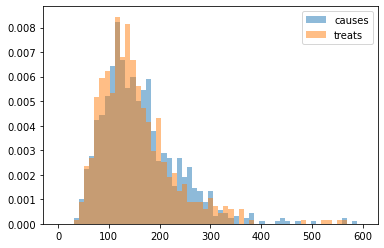

In [118]:
bins = np.linspace(0, 600, 60)

plt.hist(train_df[train_df['relation']=='causes']['chacracter count'], bins, alpha=0.5, label='causes', density=True)
plt.hist(train_df[train_df['relation']=='treats']['chacracter count'], bins, alpha=0.5, label='treats', density=True)
plt.legend(loc='upper right')
plt.show()

<ipython-input-119-9d97392b5ce7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_pred_df['chacracter count'] = false_pred_df['sentence'].apply(lambda x: len(x) - x.count(" "))


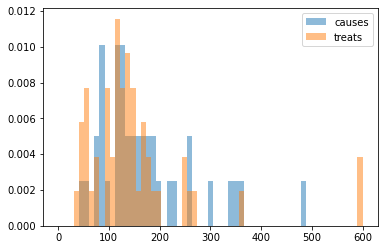

In [119]:
false_pred_df['chacracter count'] = false_pred_df['sentence'].apply(lambda x: len(x) - x.count(" "))
bins = np.linspace(0, 600, 60)

plt.hist(false_pred_df[false_pred_df['relation']=='causes']['chacracter count'], bins, alpha=0.5, label='causes', density=True)
plt.hist(false_pred_df[false_pred_df['relation']=='treats']['chacracter count'], bins, alpha=0.5, label='treats', density=True)
plt.legend(loc='upper right')
plt.show()

## Word Count

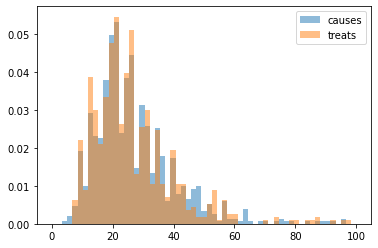

In [123]:
bins = np.linspace(0, 100, 60)

plt.hist(train_df[train_df['relation']=='causes']['word count'], bins, alpha=0.5, label='causes', density=True)
plt.hist(train_df[train_df['relation']=='treats']['word count'], bins, alpha=0.5, label='treats', density=True)
plt.legend(loc='upper right')
plt.show()

<ipython-input-125-2e4c20c7994b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_pred_df['word count'] = false_pred_df['sentence'].apply(lambda x: len(x.split()))


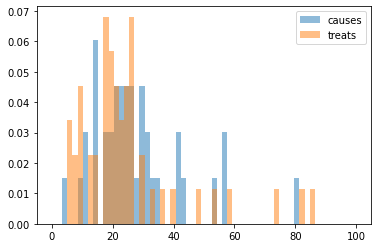

In [125]:
false_pred_df['word count'] = false_pred_df['sentence'].apply(lambda x: len(x.split()))
bins = np.linspace(0, 100, 60)

plt.hist(false_pred_df[false_pred_df['relation']=='causes']['word count'], bins, alpha=0.5, label='causes', density=True)
plt.hist(false_pred_df[false_pred_df['relation']=='treats']['word count'], bins, alpha=0.5, label='treats', density=True)
plt.legend(loc='upper right')
plt.show()

## Punctuation Count

In [135]:
import string 
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

train_df['punct%'] = train_df['sentence'].apply(lambda x: count_punct(x))
train_df.head()

,sentence,relation,body_len,chacracter count,word count,punct%
0,"For treatment of uncomplicated cervical, URETH...",treats,161,161,27,1.9
21,SALMETEROL prevented EXERCISE INDUCED ASTHMA i...,treats,79,79,16,5.1
28,The patients showed the characteristic facies ...,causes,208,208,31,2.4
35,Dyskinesias occur in the majority of patients ...,treats,199,199,34,3.5
42,ENDOTOXEMIA was evoked by bolus injection of E...,causes,248,248,42,1.6


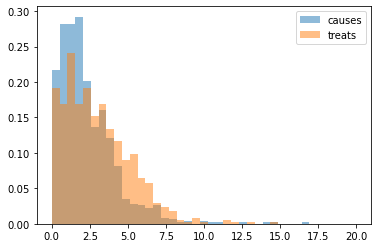

In [137]:
bins = np.linspace(0, 20, 40)

plt.hist(train_df[train_df['relation']=='causes']['punct%'], bins, alpha=0.5, label='causes', density=True)
plt.hist(train_df[train_df['relation']=='treats']['punct%'], bins, alpha=0.5, label='treats', density=True)
plt.legend(loc='upper right')
plt.show()

## TF-IDF vs CountVectorizer

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1, 3), analyzer=clean_text, use_idf=False)
X_tfidf_train = tfidf_vect.fit_transform(train_df['sentence'])
X_tfidf_train_label = train_df['relation']

'''
indices = np.argsort(tfidf_vect.idf_)[::-1]
features = tfidf_vect.get_feature_names()
top_n = 200
top_features = [features[i] for i in indices[:top_n]]
print(top_features)
'''

X_tfidf_eval = tfidf_vect.transform(validation_df['sentence'])
X_tfidf_eval_label = validation_df['relation']

X_tfidf_test = tfidf_vect.transform(test_df['sentence'])
X_tfidf_test_label = test_df['relation']

In [142]:
new_model = NuSVC()

print('Training model..')
new_model.fit(X_tfidf_train, X_tfidf_train_label)

print('{:>23} {:>12} {:>12} {:>12} {:>10}'.format('Accuracy', 'ROC_AUC', 'F1-score', 'Precision', 'Recall'))
evaluate_model(new_model, X_tfidf_train, X_tfidf_train_label, 'Train')

evaluate_model(new_model, X_tfidf_eval, X_tfidf_eval_label, 'Validation')

predictions = evaluate_model(new_model, X_tfidf_test, X_tfidf_test_label, 'Test')

Training model..
               Accuracy      ROC_AUC     F1-score    Precision     Recall
     Train      0.9653       0.9628       0.9591      0.9738       0.9448
Validation       0.806       0.8037       0.7878      0.8178       0.7598
      Test      0.8293        0.825       0.8035      0.8194       0.7881


In [143]:
enc = LabelEncoder()
gtruth = enc.fit_transform(X_tfidf_test_label)
encoder_predictions = enc.transform(predictions)
print(classification_report(gtruth, encoder_predictions, target_names=class_names))

              precision    recall  f1-score   support

      causes       0.84      0.86      0.85       297
      treats       0.82      0.79      0.80       236

    accuracy                           0.83       533
   macro avg       0.83      0.83      0.83       533
weighted avg       0.83      0.83      0.83       533



[2020-12-22 15:09:44,834] [DEBUG] [matplotlib.colorbar::_get_ticker_locator_formatter::600] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000147FA91CEE0>
[2020-12-22 15:09:44,835] [DEBUG] [matplotlib.colorbar::update_ticks::645] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000147FA91CEE0> on colorbar
[2020-12-22 15:09:44,835] [DEBUG] [matplotlib.colorbar::_add_solids::802] Setting pcolormesh


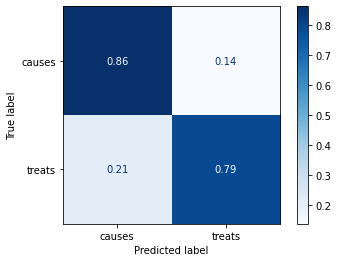

In [144]:
class_names = X_tfidf_test_label.unique()
plot_confusion_matrix(new_model, X_tfidf_test, X_tfidf_test_label,
                      display_labels=class_names,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.show()